**FD004:Random Forest**

## **Pre-processing**

In [1]:
!pip install scikit-learn==1.4.2

In [2]:
pip freeze | grep scikit-learn

scikit-learn==1.4.2


In [3]:
import numpy as np
import pandas as pd

from IPython.display import display, HTML
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio


import seaborn as sns
from importlib import reload
import matplotlib.pyplot as plt
import matplotlib
import warnings

In [ ]:
with open('train_FD004.txt', 'r') as file:
    lines = file.readlines()
column_names = ['unit number', 'time, in cycles', 'operational setting 1', 'operational setting 2', 'operational setting 3','sensor measurement  1','sensor measurement  2','sensor measurement  3', 'sensor measurement  4', 'sensor measurement  5','sensor measurement  6','sensor measurement  7','sensor measurement  8','sensor measurement  9','sensor measurement  10','sensor measurement  11','sensor measurement  12','sensor measurement  13', 'sensor measurement  14', 'sensor measurement  15', 'sensor measurement  16', 'sensor measurement  17', 'sensor measurement  18', 'sensor measurement  19','sensor measurement  20', 'sensor measurement  21',]
data = []
for line in lines:
    values = line.strip().split()
    data.append(values)

df = pd.DataFrame(data, columns=column_names)
df.to_csv('train_FD004.csv', index=False)

In [23]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
col_names = index_names + setting_names + sensor_names

# Name comes from <Damage Propagation Modeling for Aircraft Engine Run-to-failure Simulation>
col_names = index_names + setting_names + sensor_names

df_train = pd.read_csv(('train_FD004.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(('test_FD004.txt'), sep='\s+', header=None, names=col_names)

In [24]:
df_train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


In [20]:
# drop the sensors wiith constant values
sens_const_values = []
for feature in list(setting_names + sensor_names):
    try:
        if df_train[feature].min()==df_train[feature].max():
            sens_const_values.append(feature)
    except:
        pass

print(sens_const_values)
df_train.drop(sens_const_values,axis=1,inplace=True)
df_test.drop(sens_const_values,axis=1,inplace=True)

[]


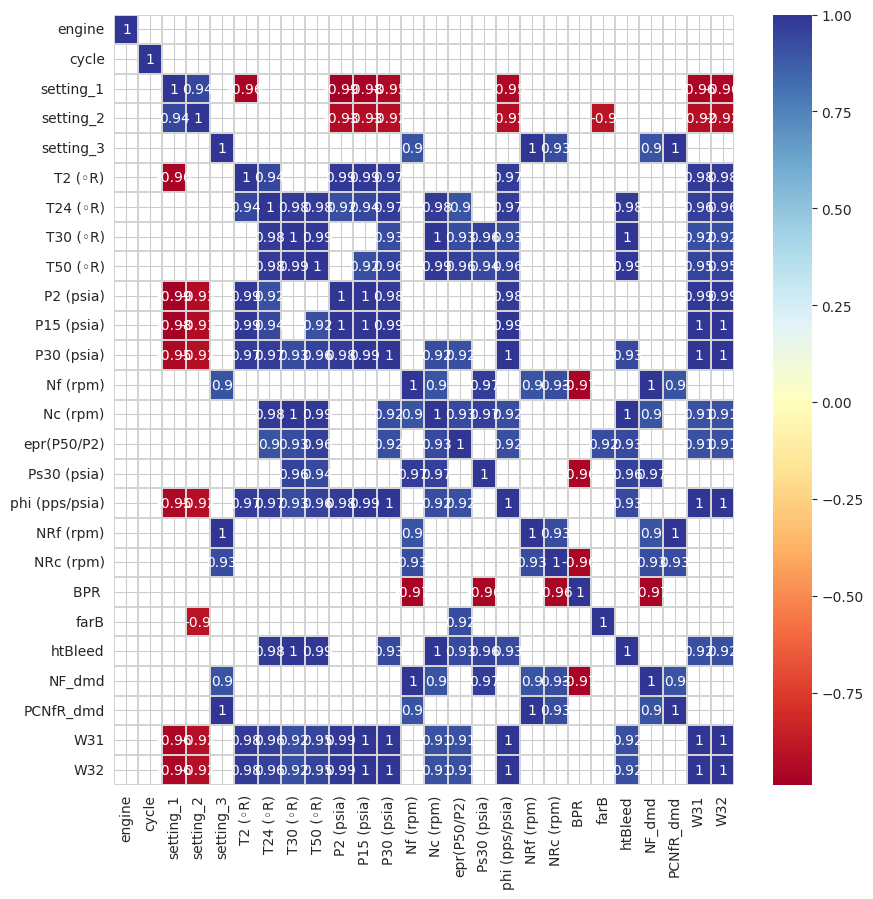

In [21]:
plt.figure(figsize=(10,10))
threshold = 0.90
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df_train.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2,
            linecolor='lightgrey').set_facecolor('white')

In [22]:
# drop one of the highly correlated features
cor_matrix = df_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]
print(corr_features)
df_train.drop(corr_features, axis=1, inplace=True)
df_test.drop(corr_features, axis=1, inplace=True)

['P15 (psia)', 'P30 (psia)', 'Nc (rpm)', 'phi (pps/psia)', 'NRf (rpm)', 'htBleed', 'NF_dmd', 'PCNfR_dmd', 'W31', 'W32']


In [24]:
features = list(df_train.columns)

In [25]:
# check for missing data
for feature in features:
    print(feature + " - " + str(len(df_train[df_train[feature].isna()])))

engine - 0
cycle - 0
setting_1 - 0
setting_2 - 0
setting_3 - 0
T2 (◦R) - 0
T24 (◦R) - 0
T30 (◦R) - 0
T50 (◦R) - 0
P2 (psia) - 0
P15 (psia) - 0
P30 (psia) - 0
Nf (rpm) - 0
Nc (rpm) - 0
epr(P50/P2) - 0
Ps30 (psia) - 0
phi (pps/psia) - 0
NRf (rpm) - 0
NRc (rpm) - 0
BPR  - 0
farB - 0
htBleed - 0
NF_dmd - 0
PCNfR_dmd - 0
W31 - 0
W32 - 0


In [26]:
df_train.dropna(axis=1, inplace=True)
df_train.dropna(axis=0, inplace=True)

In [25]:
# define the maximum life of each engine
df_train_RUL = df_train.groupby(['unit_nr']).agg({'time_cycles':'max'})
df_train_RUL.rename(columns={'time_cycles':'life'},inplace=True)
df_train_RUL.head()

,life
unit_nr,
1,321
2,299
3,307
4,274
5,193


In [26]:
df_train = df_train.merge(df_train_RUL, how='left', left_on='unit_nr', right_index=True)

df_train['RUL']=df_train['life']-df_train['time_cycles']
df_train.drop(['life'],axis=1,inplace=True)

df_train['RUL'][df_train['RUL']>125]=125
df_train.head()

<ipython-input-26-24c6a572cdd2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['RUL'][df_train['RUL']>125]=125


,unit_nr,time_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,125
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,125
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,125
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,125
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,125


In [8]:
from scipy import signal
def smooth_function(x,window=15,order=3):
    return signal.savgol_filter(x,window,order)

In [29]:
Selected_Features = []
import statsmodels.api as sm

def backward_regression(X, y, initial_list=[], threshold_out=0.05, verbose=True):
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]
backward_regression(X, y)

worst_feature : P30, 0.5637362635336841 
worst_feature : setting_2, 0.1450832077573187 
worst_feature : epr, 0.08988372486871966 
worst_feature : Nf, 0.07733394503763527 

Selected Features:
['time_cycles', 'setting_1', 'setting_3', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']


In [30]:
# X.head()
feature_names = Selected_Features[0]
np.shape(X)

(61249, 25)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

model_performance = pd.DataFrame(columns=['R2','RMSE', 'time to train','time to predict','total time'])


def R_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

In [27]:
df_test_cycle = df_test.groupby(['unit_nr']).agg({'time_cycles':'max'})
df_test_cycle.rename(columns={'time_cycles':'life'},inplace=True)
df_test_max = df_test.merge(df_test_cycle,how='left',on=['unit_nr'])
df_test_max = df_test_max[(df_test_max['time_cycles']==df_test_max['life'])]
df_test_max.drop(['life'],axis=1,inplace=True)

In [28]:
col_n = ["time_cycles"]
df_test_RUL = pd.read_csv(('RUL_FD004.txt'),  header=None, names=col_n, index_col=False)

In [ ]:
feature

In [31]:
X_train = df_train[feature_names]
y_train = df_train.iloc[:,-1]
X_test = df_test_max[feature_names]
y_test = df_test_RUL.iloc[:,-1]

## **Modeling**

In [32]:
%%time
from sklearn.ensemble import RandomForestRegressor
import time
start = time.time()
model = RandomForestRegressor(n_jobs=-1,
                              n_estimators=300,
                              min_samples_leaf=6,
                              min_samples_split=2,
                              max_features='sqrt',
                              max_depth=None
                             ).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

model_performance.loc['Random Forest'] = [model.score(X_test,y_test),
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 71.19%
Root Mean Squared Error: 29.26
CPU times: user 1min 23s, sys: 397 ms, total: 1min 24s
Wall time: 50.9 s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [33]:
X_train.columns

Index(['time_cycles', 'setting_1', 'setting_3', 'T2', 'T24', 'T30', 'T50',
       'P2', 'P15', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB',
       'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'],
      dtype='object')

In [22]:
new_cols = ['time_cycles', 'setting_1', 'setting_3', 'T2', 'T24', 'T30',
       'T50', 'P2', 'P15', 'Nc', 'Ps30',
       'phi', 'NRf', 'NRc', 'BPR ', 'farB', 'htBleed',
       'NF_dmd', 'PCNfR_dmd', 'W31', 'W32']

In [37]:
X_train.head()

,cycle,setting_1,setting_3,T2 (◦R),T24 (◦R),T30 (◦R),T50 (◦R),P2 (psia),P15 (psia),Nc (rpm),...,phi (pps/psia),NRf (rpm),NRc (rpm),BPR,farB,htBleed,NF_dmd,PCNfR_dmd,W31,W32
0,1,42.0049,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,8311.32,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,2,20.0020,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,8713.60,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,3,42.0038,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,8306.69,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,4,42.0000,100.0,445.00,548.70,1341.24,1118.03,3.91,5.70,8312.35,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,5,25.0063,60.0,462.54,536.10,1255.23,1033.59,7.05,9.00,7994.94,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


In [19]:
import pickle

In [35]:
pickle.dump(model,open("rf-fd004.h5","wb"))

In [ ]:
rf_loaded = pickle.load(open("rf-fd004.h5","rb"))

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: Save ti Google Drive

model_performance.to_csv('/content/drive/MyDrive/model_performance_FD004.csv',index=True)


In [36]:
pickle.dump(model,open("/content/drive/MyDrive/rf-fd004.h5","wb"))

In [ ]:
type(rf_loaded)

sklearn.ensemble._forest.RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import time
fixed_params = {
    'n_estimators': 300,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': None
}

param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [4, 6, 8, 10, 20],
    'max_features': ['sqrt']
}

rf = RandomForestRegressor()
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error',
                                   cv=5,
                                   n_jobs=-1,
                                   verbose=2,
                                   random_state=42)

start_tuning = time.time()
random_search.fit(X_train, y_train)

end_tuning = time.time()
best_params = random_search.best_params_
best_rf = RandomForestRegressor(**best_params)
start_training = time.time()
best_rf.fit(X_train, y_train)

end_training = time.time()
y_predictions = best_rf.predict(X_test)
r_squared = best_rf.score(X_test, y_test)
rmse = mean_squared_error(y_test, y_predictions, squared=False)

print("Best parameters found by RandomizedSearchCV:")
print(best_params)
print('R-squared error: {:.2%}'.format(r_squared))
print('Root Mean Squared Error: {:.2f}'.format(rmse))
print('Time taken for hyperparameter tuning: {:.2f} seconds'.format(end_tuning - start_tuning))
print('Time taken for model training: {:.2f} seconds'.format(end_training - start_training))


Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found by RandomizedSearchCV:
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': None}
R-squared error: 59.77%
Root Mean Squared Error: 34.58
Time taken for hyperparameter tuning: 317.58 seconds
Time taken for model training: 19.10 seconds


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import time

start = time.time()

XGBoost_model = XGBRegressor(n_estimators=500,
                     learning_rate=0.1,
                     max_depth=3,
                     min_child_weight=1,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     n_jobs=-1)

XGBoost_model.fit(X_train, y_train)

end_train = time.time()

y_predictions_XG = XGBoost_model.predict(X_test)
end_predict = time.time()

model_performance.loc['XGBoost'] = [XGBoost_model.score(X_test, y_test),
                                     mean_squared_error(y_test, y_predictions_XG, squared=False),
                                     end_train - start,
                                     end_predict - end_train,
                                     end_predict - start]

print('R-squared error: ' + "{:.2%}".format(XGBoost_model.score(X_test, y_test)))
print('Root Mean Squared Error: ' + "{:.2f}".format(mean_squared_error(y_test, y_predictions_XG, squared=False)))

R-squared error: 60.42%
Root Mean Squared Error: 34.30


<ipython-input-27-da9ba8d2e8c7>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
<ipython-input-27-da9ba8d2e8c7>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


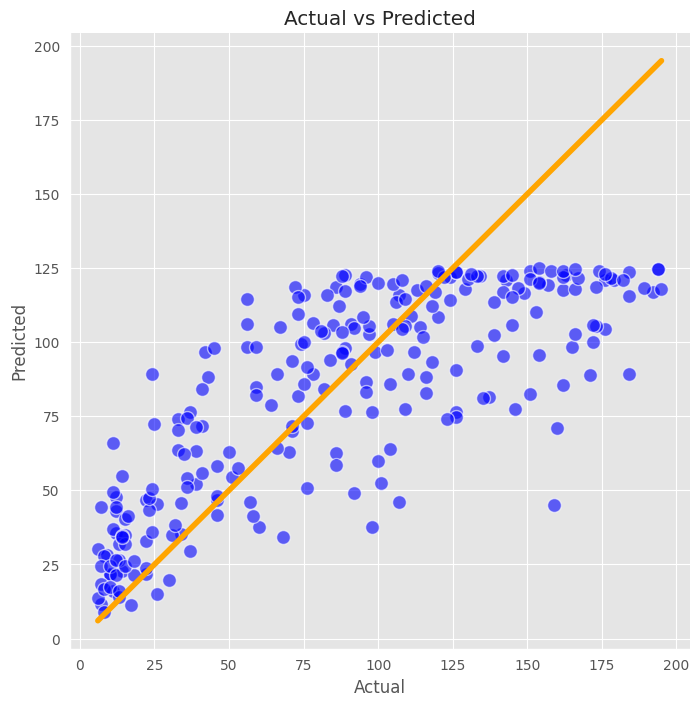

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 8))
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                    y=y_predictions,
                    s=100,
                    alpha=0.6,
                    linewidth=1,
                    color='blue',
                    ax=ax)
f = sns.lineplot(x=[min(y_test), max(y_test)],
                 y=[min(y_test), max(y_test)],
                 linewidth=4,
                 color='orange',
                 ax=ax)

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()


<ipython-input-28-b4f4b4f68dfc>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


ValueError: array length 152 does not match index length 248

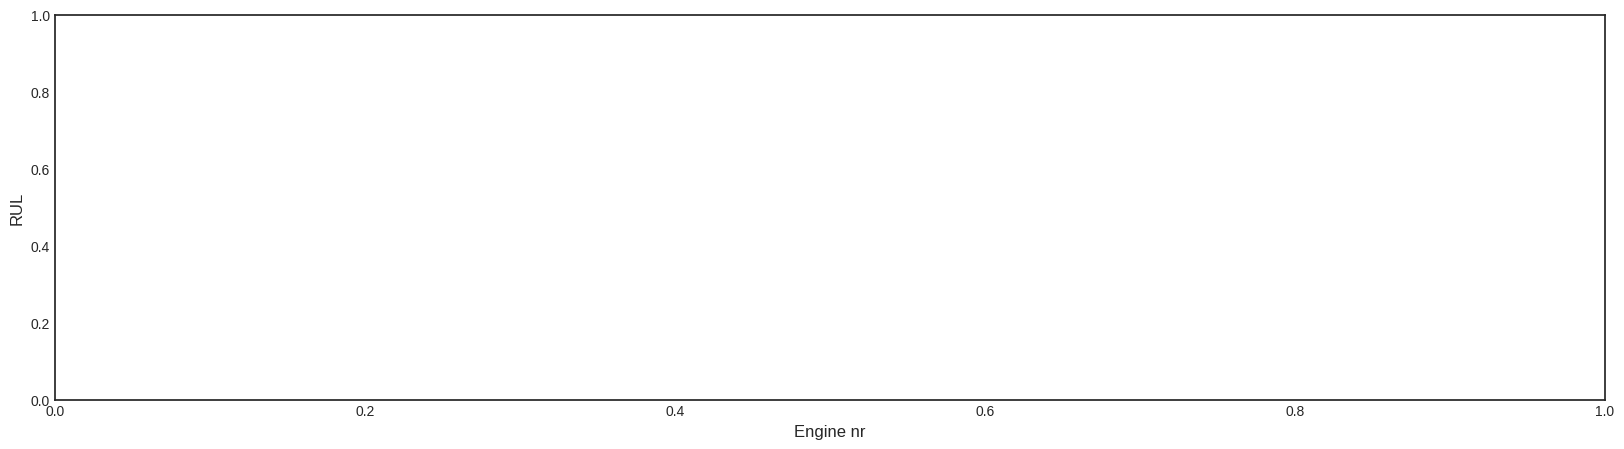

In [ ]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=20,5

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine nr')

g = sns.lineplot(x = np.arange(1,len(df_train['engine'].unique())),
                y=y_test,
                color='orange',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(1,len(df_train['engine'].unique())),
                y=y_predictions,
                color='steelblue',
                label = 'predictions',
                ax=ax)
ax.legend()

In [ ]:
RF_model.save_model('rf.h5')

NameError: name 'KNN_model' is not defined

In [ ]:
new_rf = RandomForestRegressor()
new_rf.load_model('rf.h5')

In [ ]:
model_performance.style.background_gradient(cmap='RdYlBu_r').format({
    'R2': '{:.2%}',
    'RMSE': '{:.2f}',
    'time to train': '{:.2f}',
    'time to predict': '{:.2f}',
    'total time': '{:.2f}'
})

,R2,RMSE,time to train,time to predict,total time
Random Forest,59.55%,34.68,15.04,0.08,15.11
XGBoost,60.42%,34.30,2.75,0.01,2.76
